In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as SS
import torch
from torchinfo import summary
from torch import nn
import pickle
import random
import copy
from sklearn.metrics import confusion_matrix


def seed_everything(seed=1234, is_cuda=False):
    """Some configurations for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if is_cuda:
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = True
        # torch.cuda.manual_seed(args.seed)
        torch.cuda.manual_seed_all(seed)
        

def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

Non-iid Data Allocation

In [2]:
data = pd.read_csv("D:\PyCharmProject\polyuSubject\COMP5434\data.csv")
x = data.iloc[:,:-1].values
y = data['label'].values

# scaler
scaler = SS()
x = scaler.fit_transform(x)
pickle.dump(scaler, open('scaler.pkl','wb'))

X_train, X_test, Y_train, Y_test = train_test_split(x, y, random_state=1, test_size=0.2, stratify=y)

In [3]:
print(X_train.shape, Y_train.shape)

(3200, 50) (3200,)


In [3]:
seed_everything(1234, True)
# Then Non-IID split the train dataset
def dirichlet_partition(data_label, alpha, user_num):
    index = np.arange(len(data_label))

    index_label = np.vstack((index, data_label))
    index_label = index_label[:, index_label[1,:].argsort()]

    labels = np.unique(data_label, axis=0)
    
    data_dict = data_organize(index_label, labels)
   
    data_partition_profile = {}
    for i in range(user_num):
        data_partition_profile[i] = []

    ## Distribute rest data
    for label in data_dict:
        proportions = np.random.dirichlet(np.repeat(alpha, user_num))
        proportions = len(data_dict[label]) * proportions

        for user in data_partition_profile:
            data_partition_profile[user]   \
                = set.union(set(np.random.choice(data_dict[label], int(proportions[user]) , replace = False)), data_partition_profile[user])
            data_dict[label] = list(set(data_dict[label])-data_partition_profile[user])

        while len(data_dict[label]) != 0:
            rest_data = data_dict[label][0]
            user = np.random.randint(0, user_num)
            data_partition_profile[user].add(rest_data)
            data_dict[label].remove(rest_data)

    for user in data_partition_profile:
        data_partition_profile[user] = list(data_partition_profile[user])
        np.random.shuffle(data_partition_profile[user])

    return data_partition_profile


def data_organize(index_label, labels):
    data_dict = {}

    labels = np.unique(labels, axis=0)
    for one in labels:
        data_dict[one] = []

    for i in range(len(index_label[1, :])):
        data_dict[index_label[1, i]].append(index_label[0, i])
    return data_dict

alpha = 0.5
user_num = 4
partition_result = dirichlet_partition(Y_train, alpha, user_num)
result = {}
for user in partition_result:
    X_sub = X_train[partition_result[user], :]
    y_sub = np.array(Y_train[partition_result[user]]).reshape((-1,1))
    result[user] = np.hstack((X_sub, y_sub))

x0_train = result[0][:,:-1]
y0_train = result[0][:,-1]
x1_train = result[1][:,:-1]
y1_train = result[1][:,-1]
x2_train = result[2][:,:-1]
y2_train = result[2][:,-1]
x3_train = result[3][:,:-1]
y3_train = result[3][:,-1]
print(x0_train.shape, y0_train.shape, x1_train.shape, y1_train.shape, x2_train.shape, y2_train.shape, x3_train.shape, y3_train.shape)

(580, 50) (580,) (579, 50) (579,) (974, 50) (974,) (1067, 50) (1067,)


In [4]:
seed_everything(1234, True)
class ANN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(50, 128),
            nn.ReLU(inplace=True),

            nn.Linear(128, 256),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),

            nn.Linear(128, 4),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.model(x)
        return x

net = ANN()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_func = torch.nn.CrossEntropyLoss()
batch_size = 128
summary(net)

Layer (type:depth-idx)                   Param #
ANN                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       6,528
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       33,024
│    └─Dropout: 2-4                      --
│    └─ReLU: 2-5                         --
│    └─Linear: 2-6                       65,792
│    └─Dropout: 2-7                      --
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       32,896
│    └─Dropout: 2-10                     --
│    └─ReLU: 2-11                        --
│    └─Linear: 2-12                      516
│    └─ReLU: 2-13                        --
Total params: 138,756
Trainable params: 138,756
Non-trainable params: 0

In [5]:
seed_everything(1234, True)
c0_net = ANN()
c1_net = ANN()
c2_net = ANN()
c3_net = ANN()

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def get_client_grad(client_inputs, client_labels, net_dict ,client_net):
    client_net.load_state_dict(net_dict)
    client_outputs = client_net(client_inputs)
    client_loss = loss_func(client_outputs, client_labels)
    client_optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    client_optimizer.zero_grad()
    client_loss.backward()

    # 提取梯度
    client_grad_dict = dict()  # name: params_grad
    params_modules = list(client_net.named_parameters())
    for params_module in params_modules:
        (name, params) = params_module
        params_grad = copy.deepcopy(params.grad)
        client_grad_dict[name] = params_grad
    client_optimizer.zero_grad()
    return client_grad_dict

In [6]:
seed_everything(seed=1234, is_cuda=True)
plot_train_acc = []
plot_test_acc = []
plot_train_loss = []
plot_test_loss = []
best_acc = 0
weight_epoch = []
for epoch in range(200):
    weight_record = {}
    net.train()
    for start in range(0, len(x0_train), batch_size):
        end = start + batch_size if start + batch_size < len(x0_train) else len(x0_train)
        # client1
        c0x = torch.tensor(x0_train[start:end], dtype=torch.float, requires_grad=True)
        c0y = torch.tensor(y0_train[start:end], dtype=torch.long, requires_grad=False)
        net_dict = net.state_dict()
        client_0_grad_dict = get_client_grad(c0x, c0y, net_dict, c0_net)
        # client2
        c1x = torch.tensor(x1_train[start:end], dtype=torch.float, requires_grad=True)
        c1y = torch.tensor(y1_train[start:end], dtype=torch.long, requires_grad=False)
        net_dict = net.state_dict()
        client_1_grad_dict = get_client_grad(c1x, c1y, net_dict, c1_net)
        # client3
        c2x = torch.tensor(x2_train[start:end], dtype=torch.float, requires_grad=True)
        c2y = torch.tensor(y2_train[start:end], dtype=torch.long, requires_grad=False)
        net_dict = net.state_dict()
        client_2_grad_dict = get_client_grad(c2x, c2y, net_dict, c2_net)
        # client4
        c3x = torch.tensor(x3_train[start:end], dtype=torch.float, requires_grad=True)
        c3y = torch.tensor(y3_train[start:end], dtype=torch.long, requires_grad=False)
        net_dict = net.state_dict()
        client_3_grad_dict = get_client_grad(c3x, c3y, net_dict, c3_net)
        
        client_average_grad_dict = dict()
        for key in client_0_grad_dict:
            client_average_grad_dict[key] = (client_0_grad_dict[key] + client_1_grad_dict[key] + client_2_grad_dict[key] + client_3_grad_dict[key]) / 4
        
        params_modules_server = net.named_parameters()
        for params_module in params_modules_server:
            (name, params) = params_module
            params.grad = client_average_grad_dict[name]  # 用字典中存储的子模型的梯度覆盖server中的参数梯度
        optimizer.step()
        
        for name, param in net.named_parameters():
            if 'weight' in name:
                norm = torch.norm(param)
                weight_record[name] = norm
        weight_epoch.append(weight_record)

    net.eval()
    test_batch_loss = []
    test_all_acc1 = []
    
    with torch.no_grad():
        for start in range(0, len(X_test), batch_size):
            end = start + batch_size if start + batch_size < len(X_test) else len(X_test)
            single_test_xx = torch.tensor(X_test[start:end], dtype=torch.float, requires_grad=False)
            single_test_yy = torch.tensor(Y_test[start:end], dtype=torch.long, requires_grad=False)
            test_pred = net(single_test_xx)
            test_loss = loss_func(test_pred, single_test_yy)
            test_acc1, test_acc5 = accuracy(test_pred, single_test_yy, topk=(1, 1))
            test_all_acc1.append(test_acc1.cpu().item())
            test_batch_loss.append(test_loss.data.numpy())

    test_acc = max(test_all_acc1)
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(net.state_dict(), './best_model_3.pth')

    test_loss_epoch = np.mean(test_batch_loss)

    plot_test_acc.append(test_acc)

    plot_test_loss.append(test_loss_epoch)
    if epoch % 10 == 0:
        print(epoch, test_acc, best_acc)


0 28.125 28.125
10 59.375 59.375
20 57.8125 68.75
30 63.28125 68.75
40 64.0625 68.75
50 62.5 68.75
60 56.25 68.75
70 67.96875 68.75
80 64.84375 69.53125
90 67.96875 69.53125
100 67.1875 69.53125
110 63.28125 69.53125
120 62.5 69.53125
130 64.0625 69.53125
140 60.9375 69.53125
150 54.6875 69.53125
160 58.59375 69.53125
170 61.71875 69.53125
180 57.03125 69.53125
190 52.34375 69.53125


In [10]:
weight_epoch

[{'model.0.weight': tensor(6.4737, grad_fn=<CopyBackwards>),
  'model.2.weight': tensor(9.2936, grad_fn=<CopyBackwards>),
  'model.5.weight': tensor(9.2861, grad_fn=<CopyBackwards>),
  'model.8.weight': tensor(6.5755, grad_fn=<CopyBackwards>),
  'model.11.weight': tensor(1.1374, grad_fn=<CopyBackwards>)},
 {'model.0.weight': tensor(6.4737, grad_fn=<CopyBackwards>),
  'model.2.weight': tensor(9.2936, grad_fn=<CopyBackwards>),
  'model.5.weight': tensor(9.2861, grad_fn=<CopyBackwards>),
  'model.8.weight': tensor(6.5755, grad_fn=<CopyBackwards>),
  'model.11.weight': tensor(1.1374, grad_fn=<CopyBackwards>)},
 {'model.0.weight': tensor(6.4737, grad_fn=<CopyBackwards>),
  'model.2.weight': tensor(9.2936, grad_fn=<CopyBackwards>),
  'model.5.weight': tensor(9.2861, grad_fn=<CopyBackwards>),
  'model.8.weight': tensor(6.5755, grad_fn=<CopyBackwards>),
  'model.11.weight': tensor(1.1374, grad_fn=<CopyBackwards>)},
 {'model.0.weight': tensor(6.4737, grad_fn=<CopyBackwards>),
  'model.2.weight'

In [14]:
in_weight = []
h1_weight = []
h2_weight = []
h3_weight = []
out_weight = []
for epoch in range(200):
    in_weight.append(weight_epoch[epoch]['model.0.weight'].item())
    h1_weight.append(weight_epoch[epoch]['model.2.weight'].item())
    h2_weight.append(weight_epoch[epoch]['model.5.weight'].item())
    h3_weight.append(weight_epoch[epoch]['model.8.weight'].item())
    out_weight.append(weight_epoch[epoch]['model.11.weight'].item())
in_weight_delta = []
h1_weight_delta = []
h2_weight_delta = []
h3_weight_delta = []
out_weight_delta = []
for epoch in range(2, 199):
    in_weight_delta.append((in_weight[epoch+1]-in_weight[epoch])/in_weight[epoch])
    h1_weight_delta.append((h1_weight[epoch+1]-h1_weight[epoch])/h1_weight[epoch])
    h2_weight_delta.append((h2_weight[epoch+1]-h2_weight[epoch])/h2_weight[epoch])
    h3_weight_delta.append((h3_weight[epoch+1]-h3_weight[epoch])/h3_weight[epoch])
    out_weight_delta.append((out_weight[epoch+1]-out_weight[epoch])/out_weight[epoch])

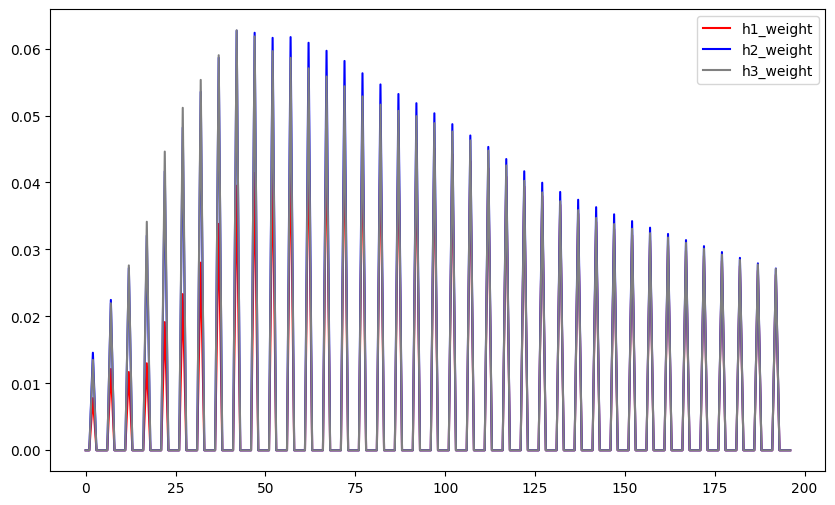

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10, 6])
# plt.plot(range(0, len(in_weight_delta)), in_weight_delta)
plt.plot(range(0, len(in_weight_delta)), h1_weight_delta, color='red')
plt.plot(range(0, len(in_weight_delta)), h2_weight_delta, color='blue')
plt.plot(range(0, len(in_weight_delta)), h3_weight_delta, color='gray')
# plt.plot(range(0, len(in_weight_delta)), out_weight_delta)
plt.legend(['h1_weight', 'h2_weight', 'h3_weight'])
plt.show()

plot the weight changing rate in adjacent epochs, which proves that Non-IID makes the training process unstable.

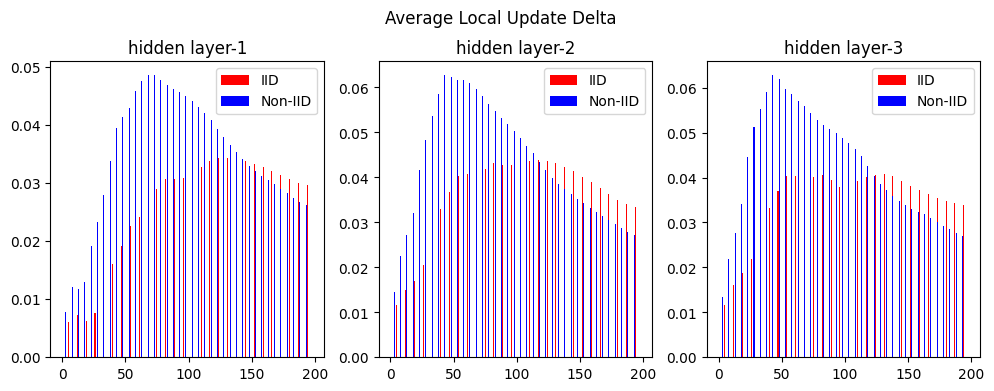

In [30]:
iid_delta = pd.read_csv("delta_iid.csv")
h1_iid = iid_delta['h1_weight_delta'].to_list()
h2_iid = iid_delta['h2_weight_delta'].to_list()
h3_iid = iid_delta['h3_weight_delta'].to_list()
index = list(range(1, 198))
# print(index, len(index))
# print(h1_iid, len(h1_iid))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.bar(index, h1_iid, color='red')
ax1.bar(index, h1_weight_delta, color='blue')
ax1.set_title('hidden layer-1')
ax1.legend(['IID', 'Non-IID'])

ax2.bar(index, h2_iid, color='red')
ax2.bar(index, h2_weight_delta, color='blue')
ax2.set_title('hidden layer-2')
ax2.legend(['IID', 'Non-IID'])

ax3.bar(index, h3_iid, color='red')
ax3.bar(index, h3_weight_delta, color='blue')
ax3.set_title('hidden layer-3')
ax3.legend(['IID', 'Non-IID'])
fig.suptitle('Average Local Update Delta')
fig.subplots_adjust(top=0.85)

Text(0.5, 1.0, 'Test Loss on Non-IID data')

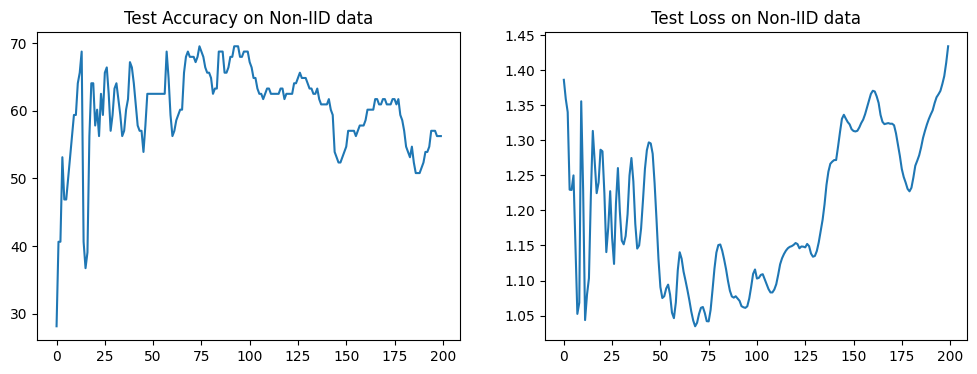

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(range(0, 200), plot_test_acc)
ax1.set_title('Test Accuracy on Non-IID data')

ax2.plot(range(0, 200), plot_test_loss)
ax2.set_title('Test Loss on Non-IID data')

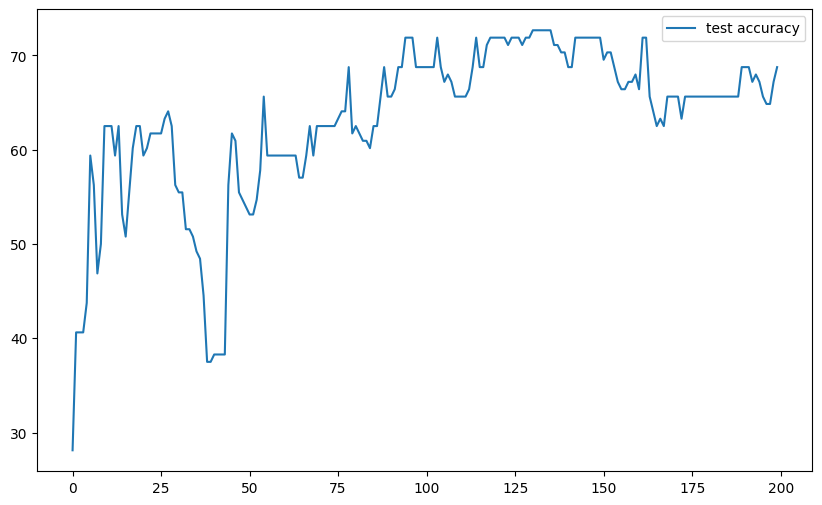

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=[10, 6])
plt.plot(range(0, 200), plot_test_acc)
plt.legend(['test accuracy'])
plt.show()

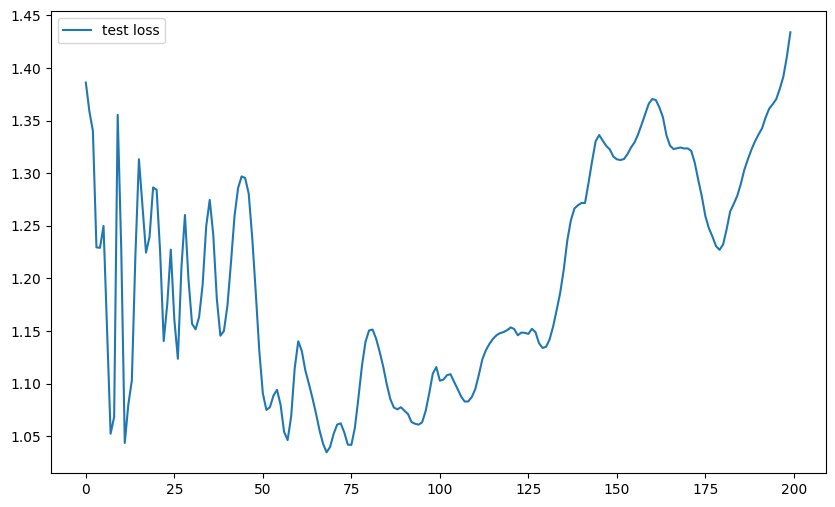

In [11]:
plt.figure(figsize=[10, 6])
plt.plot(range(0, 200), plot_test_loss)
plt.legend(['test loss'])
plt.show()